# 目標
- Lorenz96モデルにおける、Strong-constraint 4D-Varによるパラメータ同時推定の双子実験
- systems biologyにおける、ヒル式的活性化反応のcontrol variableと、パラメータ推定を含むStrong-constraint 4D-Varコードの作成と双子実験
- Weak-constraint 4D-Varコードの実装 ← 途中
- 二次変分によるパラメータと状態変数の信頼区間推定
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装

## Lorenz96モデルにおける、Strong-constraint 4D-Varによるパラメータ同時推定の双子実験

T 1.0
day 5.0


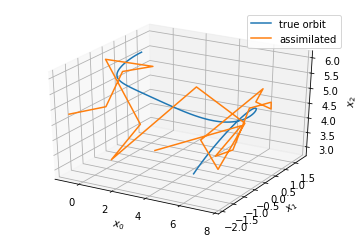

Before assimilation
cost 586.267887981


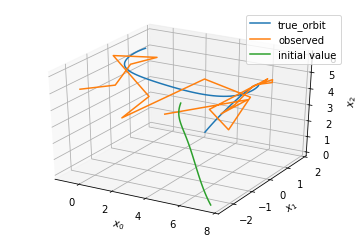

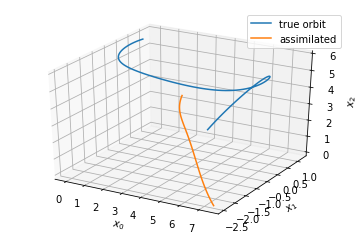

Analytical and numerical gradient comparison
gr_anal [ -30.28768019    3.54203173  -69.2443428    13.0582833    70.04015989
   45.44332176   -2.15085172    2.71890835 -166.0510012 ]
gr_num [ -29.60565207    3.0637912   -68.08047297   12.70155791   69.51734824
   45.51908143   -3.07191821    3.20934352 -164.51459813]
relative error [ 0.02303709  0.15609436  0.0170955   0.02808517  0.00752059 -0.00166435
 -0.29983431 -0.15281479  0.00933901]
      fun: 67.919306849555653
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.08576727, -0.04670636, -0.13937823,  0.17346226,  0.04011222,
        0.11867387,  0.03294659,  0.08223859,  0.3594318 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 77
      nit: 46
   status: 0
  success: True
        x: array([ 5.57664764, -1.03883622,  3.56122811,  3.57073044, -1.7230897 ,
       -0.45224262,  2.99178257,  8.4031845 ,  1.05927157])
true x0 [ 6.400706 -1.873827  3.664105  3.516149 -2.240415 -0.049

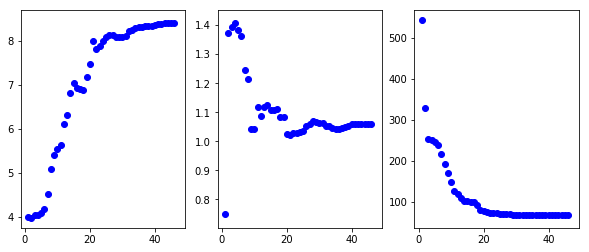

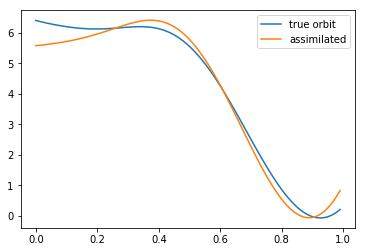

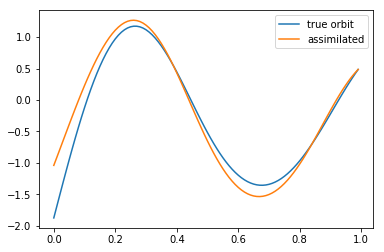

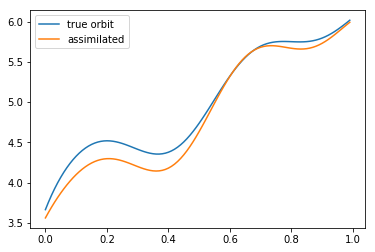

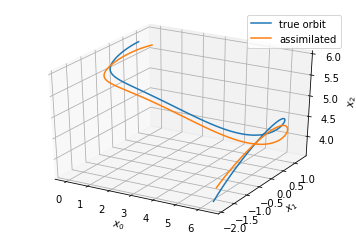

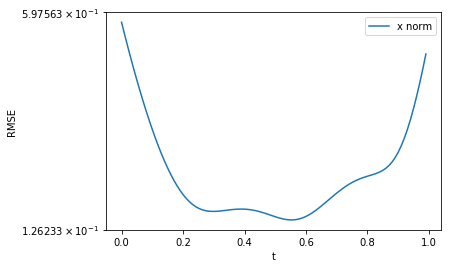

RMSE:  0.15771544815
4DVar optimal cost:  67.9193068496
true cost:  72.9340998081


In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

count = 0

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N):
        self.N = N # number of variables
        self.M = 2 # number of parameters
    def gradient(self,x):
        d = np.zeros(self.N + self.M)
        d[0]        = x[self.N+1] * (x[1]   - x[self.N-2]) * x[self.N-1] - x[0]        + x[self.N]
        d[1]        = x[self.N+1] * (x[2]   - x[self.N-1]) * x[0]        - x[1]        + x[self.N]
        for i in range(2, self.N-1):
            d[i]    = x[self.N+1] * (x[i+1] - x[i-2])      * x[i-1]      - x[i]        + x[self.N]
        d[self.N-1] = x[self.N+1] * (x[0]   - x[self.N-3]) * x[self.N-2] - x[self.N-1] + x[self.N]
        return d
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N + self.M ,self.N + self.M))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == j):
                    mt[j][i] += x[self.N+1] * (x[(i+1) % self.N] - x[(i-2) % self.N])
                if (((i+1) % self.N) == j):
                    mt[j][i] += x[self.N+1] * x[(i-1) % self.N]
                if (((i-2) % self.N) == j):
                    mt[j][i] -= x[self.N+1] * x[(i-1) % self.N]
                if ((i     % self.N) == j):
                    mt[j][i] -= 1
            mt[N][i] = 1
            mt[N+1][i] = (x[(i+1) % self.N] - x[(i-2) % self.N]) * x[(i-1) % self.N]
        gr = mt @ la
        return gr

class RungeKutta4:
    def __init__(self, callback, N, dt, t, x):
        self.callback = callback
        self.N = N
        self.dt = dt
        self.t = t
        self.x = x
        self.M = 2

    def nextstep(self):
        k1 = handler(self.callback, self.x)
        k2 = handler(self.callback, self.x + k1*self.dt/2)
        k3 = handler(self.callback, self.x + k2*self.dt/2)
        k4 = handler(self.callback, self.x + k3*self.dt)
        self.t += self.dt
        self.x += (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def orbit(self,T):
        steps = int(T/self.dt) + 1
        o = np.zeros((steps,self.N + self.M))
        o[0] = self.x
        for i in range(steps):
            o[i] = self.nextstep()
        return o
    
    def nextstep_gradient(self):
        self.nextstep()
        return self.dt * self.callback(self.t, self.x)
    
    def orbit_gradient(self, T):
        steps = int(T/self.dt)
        gr = np.zeros((steps, self.N + self.M))
        gr[0] = self.dt * self.callback(self.t, self.x)
        for i in range(steps):
            gr[i] = self.nextstep_gradient()
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, x, y):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.M = 2
        
    def orbit(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dx, self.x[i])
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, self.x[i] + k3*self.dt)
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def gradient(self):
        la = np.zeros((self.minute_steps, self.N + self.M))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6            
            for j in range(self.N):
                la[self.it*i][j] += self.x[self.it*i][j] - self.y[i][j]
        return la[0]

    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        la = np.zeros((self.minute_steps, self.N + self.M))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            for j in range(self.N):
                la[self.it*i][j] += self.x[self.it*i][j] - self.y[i][j]
        return la[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(self.N + self.M)
        c1 = self.cost(x0)
        for j in range(self.N + self.M):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr
    
    def cbf(self, x0):
        global count, axL, axR
        count += 1
        axLL.scatter(count, x0[self.N], c='b')
        axL.scatter(count, x0[self.N+1], c='b')
        axR.scatter(count, self.cost(x0), c='b')

#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/data/" + str(N) + "/"

M = 2
F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1

lorenz = Lorenz96(N)

tob = np.loadtxt(pref + "year.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)

x_opt = np.zeros(N + M)
x_opt[0:N] = np.loadtxt(pref + "year.2.dat")[np.random.randint(len(tob))]
x_opt[N] = 4 # initial guess for F
x_opt[N+1] = 0.5 # initial guess for a

x = np.zeros((minute_steps, N + M))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, x, obs)

print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(tob[0:minute_steps], obs[0:steps], scheme.x[:,0:N], 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps], scheme.x[:,0:N])

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.00001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
global axL
global axR
fig , (axLL, axL, axR) = plt.subplots(ncols=3, figsize=(10,4), sharex=False)
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
print (res)
print ("true x0", tob[0])

for j in range(3):
#for j in range(N):
    fig = plt.figure()
    plt.plot(t, tob[0:minute_steps,j], label='true orbit')
    plt.plot(t, scheme.x[0:minute_steps,j], label='assimilated')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps], scheme.x[:,0:N])

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, tob, obs)
print('true cost: ', scheme_true.true_cost())


In [34]:
true_param = np.array([8., 1.])
param_rmse = np.linalg.norm(res.x[N:N+M] - true_param)/math.sqrt(2)
print("True_Param:", true_param)
print("Estimated_Param:", res.x[N:N+M])
print ("RMSE_Param:", param_rmse)

True_Param: [ 8.  1.]
Estimated_Param: [ 8.4031845   1.05927157]
RMSE_Param: 0.288158691325


T 1.0
day 5.0


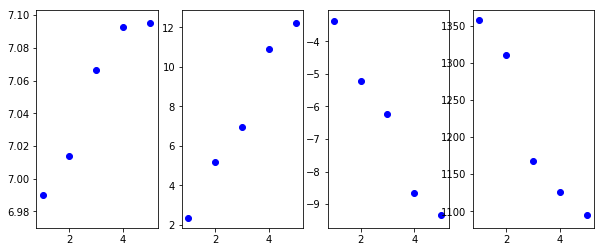

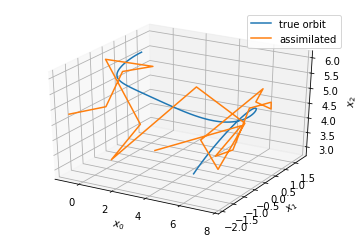

Before assimilation
cost 1198.76307545


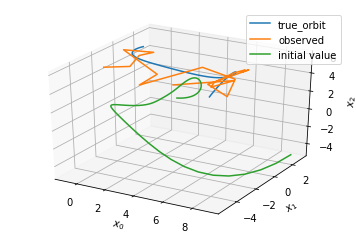

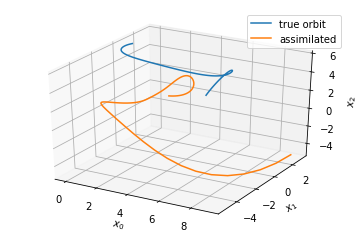

Analytical and numerical gradient comparison
gr_anal [ -46.19599858   68.07512222  -60.96327766  -77.9816579     1.33040002
  124.27011599  191.06173858  -16.20522896 -105.74773001  123.24781389]
gr_num [ -31.89463741   41.36919902  -62.00644009  -59.54623634   10.81666885
   93.74965641  142.58014894  -20.36534429  -68.82574187   84.17765209]
relative error [ 0.44839391  0.64555089 -0.01682345  0.30959843 -0.87700465  0.32555276
  0.34003043 -0.20427425  0.53645609  0.46413936]
      fun: 67.053590401801685
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.05411431, -0.34475144, -0.22773398,  0.54148744, -0.0640112 ,
       -0.02803413,  0.45977006,  0.06460658,  1.8566201 ,  1.39473557])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 152
      nit: 85
   status: 0
  success: True
        x: array([ 5.5149615 , -0.87914639,  3.5589469 ,  3.34759455, -1.74625427,
       -0.16577979,  2.75815923,  7.56246985,  0.99576921, -0.8237278

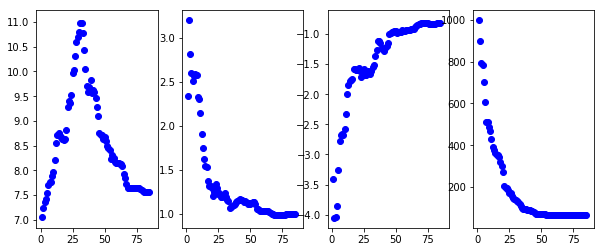

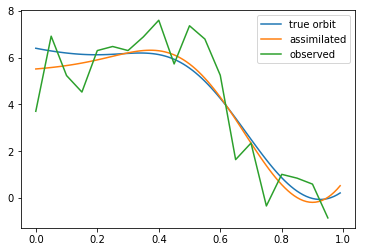

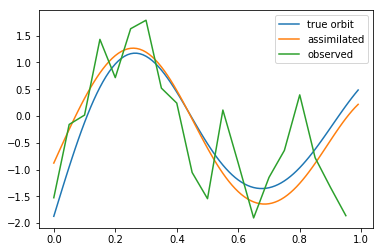

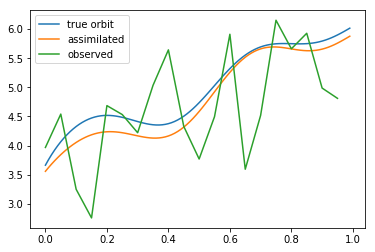

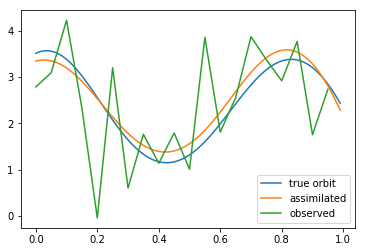

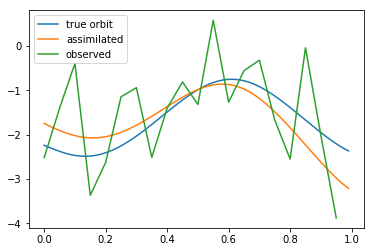

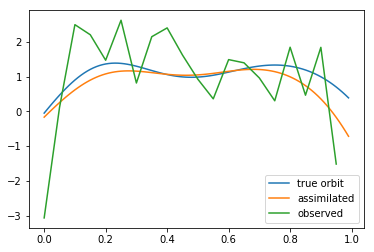

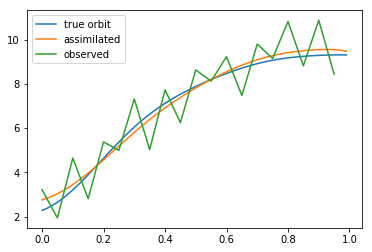

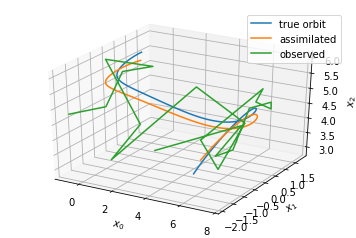

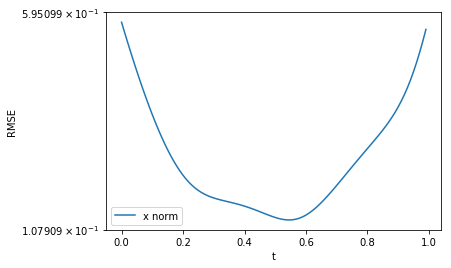

RMSE: 0.141123098251
RMSE_natural_variability: 5.29043166363
4DVar optimal cost:  67.0535904018
true cost:  72.9340998081


In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

count = 0

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N):
        self.N = N # number of variables
        self.M = 3 # number of parameters
    def gradient(self,x):
        d = np.zeros(self.N + self.M)
        d[0]        = x[self.N+1] * (x[1]   - x[self.N-2]) * x[self.N-1] + x[self.N+2] * x[0]        + x[self.N]
        d[1]        = x[self.N+1] * (x[2]   - x[self.N-1]) * x[0]        + x[self.N+2] * x[1]        + x[self.N]
        for i in range(2, self.N-1):
            d[i]    = x[self.N+1] * (x[i+1] - x[i-2])      * x[i-1]      + x[self.N+2] * x[i]        + x[self.N]
        d[self.N-1] = x[self.N+1] * (x[0]   - x[self.N-3]) * x[self.N-2] + x[self.N+2] * x[self.N-1] + x[self.N]
        return d
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N + self.M ,self.N + self.M))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == j):
                    mt[j][i] += x[self.N+1] * (x[(i+1) % self.N] - x[(i-2) % self.N])
                if (((i+1) % self.N) == j):
                    mt[j][i] += x[self.N+1] * x[(i-1) % self.N]
                if (((i-2) % self.N) == j):
                    mt[j][i] -= x[self.N+1] * x[(i-1) % self.N]
                if ((i     % self.N) == j):
                    mt[j][i] += x[self.N+2]
            mt[N][i] = 1
            mt[N+1][i] = (x[(i+1) % self.N] - x[(i-2) % self.N]) * x[(i-1) % self.N]
            mt[N+2][i] = x[i]
        gr = mt @ la
        return gr

class RungeKutta4:
    def __init__(self, callback, N, dt, t, x):
        self.callback = callback
        self.N = N
        self.dt = dt
        self.t = t
        self.x = x
        self.M = 3

    def nextstep(self):
        k1 = handler(self.callback, self.x)
        k2 = handler(self.callback, self.x + k1*self.dt/2)
        k3 = handler(self.callback, self.x + k2*self.dt/2)
        k4 = handler(self.callback, self.x + k3*self.dt)
        self.t += self.dt
        self.x += (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def orbit(self,T):
        steps = int(T/self.dt) + 1
        o = np.zeros((steps,self.N + self.M))
        o[0] = self.x
        for i in range(steps):
            o[i] = self.nextstep()
        return o
    
    def nextstep_gradient(self):
        self.nextstep()
        return self.dt * self.callback(self.t, self.x)
    
    def orbit_gradient(self, T):
        steps = int(T/self.dt)
        gr = np.zeros((steps, self.N + self.M))
        gr[0] = self.dt * self.callback(self.t, self.x)
        for i in range(steps):
            gr[i] = self.nextstep_gradient()
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, x, y):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.M = 3
        
    def orbit(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dx, self.x[i])
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, self.x[i] + k3*self.dt)
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def gradient(self):
        la = np.zeros((self.minute_steps, self.N + self.M))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6            
            for j in range(self.N):
                la[self.it*i][j] += self.x[self.it*i][j] - self.y[i][j]
        return la[0]

    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        la = np.zeros((self.minute_steps, self.N + self.M))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            for j in range(self.N):
                la[self.it*i][j] += self.x[self.it*i][j] - self.y[i][j]
        return la[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(self.N + self.M)
        c1 = self.cost(x0)
        for j in range(self.N + self.M):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr
    
    def cbf(self, x0):
        global count, axL, axR, axRR
        count += 1
        axLL.scatter(count, x0[self.N], c='b')
        axL.scatter(count, x0[self.N+1], c='b')
        axR.scatter(count, x0[self.N+2], c='b')
        axRR.scatter(count, self.cost(x0), c='b')

#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/data/" + str(N) + "/"

M = 3
F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1

lorenz = Lorenz96(N)

tob = np.loadtxt(pref + "year.1.dat")
tob2 = np.loadtxt(pref + "year.2.dat")
#covariance_tob = np.cov(np.transpose(np.asarray(tob[0:minute_steps])))
#root_mean_trace_cov_tob = np.sqrt(np.trace(covariance_tob)/N)

RMSE_natural_variability = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,len(tob))])
#RMSE_natural_variability_T = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,minute_steps)])

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")
#covariance_obs = np.cov(np.transpose(np.asarray(obs[0:steps])))
#root_mean_trace_cov_obs = np.sqrt(np.trace(covariance_obs)/N)

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

x_opt = np.zeros(N + M)
x_opt[0:N] = np.loadtxt(pref + "year.2.dat")[np.random.randint(len(tob))]
x_opt[N] = 7 # initial guess for F
x_opt[N+1] = 2 # initial guess for a
x_opt[N+2] = -3 # initial guess for b

x = np.zeros((minute_steps, N + M))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, x, obs)

print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(tob[0:minute_steps], obs[0:steps], scheme.x[:,0:N], 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps], scheme.x[:,0:N])

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.00001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
global axL
global axR
fig , (axLL, axL, axR, axRR) = plt.subplots(ncols=4, figsize=(10,4), sharex=False)
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
print (res)
print ("true x0", tob[0])

#for j in range(3):
for j in range(N):
    fig = plt.figure()
    plt.plot(t, tob[0:minute_steps,j], label='true orbit')
    plt.plot(t, scheme.x[0:minute_steps,j], label='assimilated')
    plt.plot(t_it, obs[0:steps, j], label='observed')
    plt.legend()
    plt.show()

compare_orbit3(tob[0:minute_steps], scheme.x[:,0:N], obs[0:steps], 'true orbit', 'assimilated', 'observed')

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE:", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))
#print ("RootMeanTr(cov(true)):", root_mean_trace_cov_tob)
#print ("RootMeanTr(cov(obs)):", root_mean_trace_cov_obs)
print ("RMSE_natural_variability:", RMSE_natural_variability)
#print ("RMSE_natural_variability_T:", RMSE_natural_variability_T)

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, tob, obs)
print('true cost: ', scheme_true.true_cost())

#%%
#slight_different_x0 = np.zeros(N + M)
#slight_different_x0[0:N] = np.copy(tob[0])
#slight_different_x0[N] = 8
#slight_different_x0[N+1] = 1
#slight_different_x0[N+2] = -1
#slight_different_x0[0] += 0.01
#rk4 = RungeKutta4(lorenz.gradient, N, dt, t, slight_different_x0)
#test_T = 2.0
#slight_different_orb = rk4.orbit(test_T)
#curr_steps = int(test_T/dt)
#
#compare_orbit(tob[0:curr_steps], slight_different_orb[0:curr_steps,0:N])


In [32]:
true_param = np.array([8., 1., -1.])
param_rmse = np.linalg.norm(res.x[N:N+M] - true_param)/math.sqrt(M)
print("True_Param:", true_param)
print("Estimated_Param:", res.x[N:N+M])
print ("RMSE_Param:", param_rmse)

True_Param: [ 8.  1. -1.]
Estimated_Param: [ 7.56246985  0.99576921 -0.82372785]
RMSE_Param: 0.272349286205


## systems biologyにおける、ヒル式的活性化反応のcontrol variableと、パラメータ推定を含むStrong-constraint 4D-Varコードの作成と双子実験

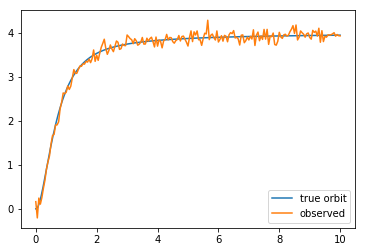

Before assimilation
cost 24949.4967643


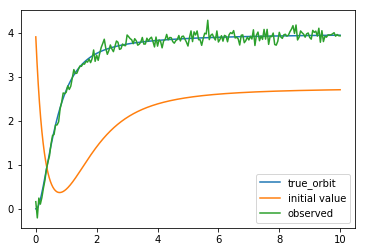

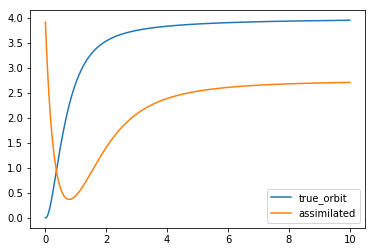

Analytical and numerical gradient comparison
gr_anal [   923.31481289 -14194.71509824  -5371.94979631  11645.50261404
  -2601.64720917]
gr_num [   920.71995823 -14189.01855504  -5362.67920688  11632.37941728
  -2594.77336294]
relative error [ 0.00281829  0.00040148  0.00172872  0.00112816  0.00264911]
      fun: 94.494345974906125
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.4155709 ,  0.02979977, -0.09636045,  0.01794239,  0.0121041 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 38
      nit: 23
   status: 0
  success: True
        x: array([  0.        ,  -2.85445751,  11.4293878 ,   0.31543126,   1.29419056])
true x0 [ 0.]


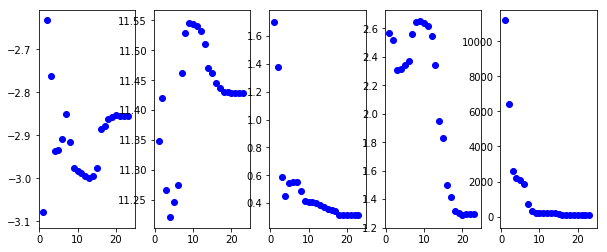

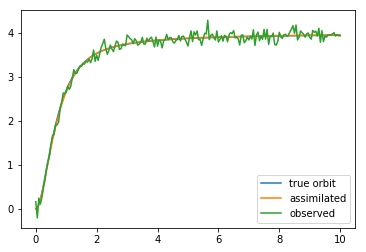

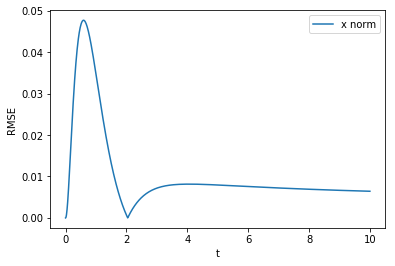

RMSE: 0.00791916754869
RMSE_natural_variability: 0.016917915
4DVar optimal cost:  94.4943459749
true cost:  96.5593880894


In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math
import scipy.stats

count = 0

def handler(func, *args):
    return func(*args)

#%%
class Hill:
    def __init__(self, ctrl):
        self.ctrl = ctrl
        self.N = 1
        self.M = 4 # x0=x, x1=a, x2=b, x3=K, x4=n

    def gradient(self, t, x):
        u = self.ctrl(t)
        
        u_n = math.pow(u, x[4])
        K_n = math.pow(x[3], x[4])

        d = np.zeros(self.N + self.M)
        d[0] = x[1] * x[0] + x[2] * u_n / (K_n + u_n)
                
        return d
        
    def gradient_adjoint(self, la, t, x):
        u = self.ctrl(t)
        
        d = np.zeros(self.N + self.M)
        d[0] = x[1] * la[0]
        d[1] = x[0] * la[0]
        
        if(u > 0):
            try:
                l_K_over_u = math.log(x[3]/u)
                n_l_K_over_u = x[4] * l_K_over_u                
                cosh_n_l_K_over_u = math.cosh(n_l_K_over_u)
                d[2] = la[0] / (1.0 + math.exp(n_l_K_over_u))
                d[3] = - x[2] * x[4] / 2.0 / x[3] / (1.0 + cosh_n_l_K_over_u) * la[0] # else d[3] = 0. fixed
                d[4] = - x[2] * l_K_over_u / 2.0 / (1.0 + cosh_n_l_K_over_u) * la[0]  # else d[4] = 0. fixed
            except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
                d[2] = 0.
                d[3] = 0.
                d[4] = 0.
        return d

def ramp(t):
    return t

def impulse(t):
    return scipy.stats.norm.pdf(t, 0, 0.1)

def rect(t):
    if (t <= 5):
        return 1.
    else:
        return 0.
    
def zero(t):
    return 0.

def sin(t):
    return 1.0 + math.sin(t)

def cos(t):
    return 1.0 + math.cos(t)

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, x, y, stddev):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.M = 4
        self.stddev = stddev
        
    def orbit(self):
        self.t = 0.
        for i in range(self.minute_steps):
            time = float(i) / self.minute_steps * self.T
            k1 = handler(self.dx, time             , self.x[i])
            k2 = handler(self.dx, time + self.dt/2., self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, time + self.dt/2., self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, time + self.dt   , self.x[i] + k3*self.dt)
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            self.t += self.dt
        return self.x
    
    def observed(self):
        self.orbit()
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += self.stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self):
        tob = np.copy(self.orbit())
        for i in range(self.steps + 1):
            for j in range(self.N):
                self.x[i,j] += self.stddev * np.random.randn() # fixed
        return tob, self.x
    
    def gradient(self):
        self.t = self.T
        la = np.zeros((self.minute_steps + 1, self.N + self.M))
        for j in range(self.N):
            la[self.minute_steps][j] = (self.x[self.minute_steps][j] - self.y[self.steps][j]) / self.stddev**2
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                time = float(n) / self.minute_steps * self.T
                if (n < self.it*self.steps):
                    p1 = handler(self.dx, time             , self.x[n])
                    p2 = handler(self.dx, time + self.dt/2., self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, time + self.dt/2., self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, time + self.dt   , self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1]               , time + self.dt   , self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, time + self.dt/2., self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, time + self.dt/2., self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt  , time             , self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            for j in range(self.N):
                la[self.it*i][j] += (self.x[self.it*i][j] - self.y[i][j]) / self.stddev**2
        return la[0]

    def gradient_from_x0(self, x0):
        self.t = self.T
        self.x[0] = x0
        self.orbit()
        la = np.zeros((self.minute_steps + 1, self.N + self.M))
        for j in range(self.N):
            la[self.minute_steps][j] = (self.x[self.minute_steps][j] - self.y[self.steps][j]) / self.stddev**2
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                time = float(n) / self.minute_steps * self.T
                if (n < self.it*self.steps):
                    p1 = handler(self.dx, time             , self.x[n])
                    p2 = handler(self.dx, time + self.dt/2., self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, time + self.dt/2., self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, time + self.dt   , self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1]               , time + self.dt   , self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, time + self.dt/2., self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, time + self.dt/2., self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt  , time             , self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            for j in range(self.N):
                la[self.it*i][j] += (self.x[self.it*i][j] - self.y[i][j]) / self.stddev**2
        return la[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps + 1):
            cost += ((self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])) / self.stddev**2
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps + 1):
            cost += ((self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])) / self.stddev**2
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(self.N + self.M)
        c1 = self.cost(x0)
        for j in range(self.N + self.M):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr
    
    def cbf(self, x0):
        global count, axLL, axL, axR, axRR, axRRR
        count += 1
        axLL.scatter(count, x0[self.N], c='b')
        axL.scatter(count, x0[self.N+1], c='b')
        axR.scatter(count, x0[self.N+2], c='b')
        axRR.scatter(count, x0[self.N+3], c='b')
        axRRR.scatter(count, self.cost(x0), c='b')

#%%
def plot_orbit(t, dat, lab):
    fig = plt.figure()
    plt.plot(t, dat, label=lab)
    plt.legend()
    plt.show()

def compare_orbit(t1, t2, dat1, dat2, lab1, lab2):
    fig = plt.figure()
    plt.plot(t1, dat1, label=lab1)
    plt.plot(t2, dat2, label=lab2)
    plt.legend()
    plt.show()

def compare_orbit3(t1, t2, t3, dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    plt.plot(t1, dat1, label=label1)
    plt.plot(t2, dat2, label=label2)
    plt.plot(t3, dat3, label=label3)
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize
np.seterr(invalid='raise')

N = 1
stddev = 0.1

ctrl = ramp
pref = "/Users/konta/bitbucket/androsace/dacamp/hill/data/" + ctrl.__name__ + "/" + str(N) + "/"

M = 4
dt = 0.01

T = 10.
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

hill = Hill(ctrl)

tob = np.loadtxt(pref + "true.1.dat", ndmin=2)
tob2 = np.loadtxt(pref + "true.2.dat", ndmin=2)
#covariance_tob = np.cov(np.transpose(np.asarray(tob[0:minute_steps])))
#root_mean_trace_cov_tob = np.sqrt(np.trace(covariance_tob)/N)

RMSE_natural_variability = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,len(tob))])
#RMSE_natural_variability_T = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,minute_steps)])

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat", ndmin=2)
#covariance_obs = np.cov(np.transpose(np.asarray(obs[0:steps])))
#root_mean_trace_cov_obs = np.sqrt(np.trace(covariance_obs)/N)

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

t_plus_1 = np.arange(0., T+dt, dt)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

compare_orbit(t_plus_1, t_it_plus_1, tob[0:minute_steps+1], obs[0:steps+1], 'true orbit', 'observed')

x_opt = np.zeros(N + M)
x_opt[0:N] = tob2[np.random.randint(len(tob))]
#x_opt[0] = 0
x_opt[N] = -4.  # initial guess for a (a_true = -3.)
x_opt[N+1] = 11.  # initial guess for b (b_true = 12.)
x_opt[N+2] = 1.7  # initial guess for K (K_true = 0.3132)
x_opt[N+3] = 2.4 # initial guess for n (n_true = 1.276)

x = np.zeros((minute_steps + 1, N + M))
scheme = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, x, obs, stddev)

print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1, 0], obs[0:steps+1, 0], 'true_orbit', 'initial value', 'observed')
compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], 'true_orbit', 'assimilated')

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.000001)
print ("gr_num", gr_num)
if not(0 in gr_num):
    print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
global axLL, axL, axR, axRR, axRRR
fig , (axLL, axL, axR, axRR, axRRR) = plt.subplots(ncols=5, figsize=(10,4), sharex=False)
bnds = ((0, None), (None, None), (None, None), (0.1, None), (0, None))
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', bounds=bnds, callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
print (res)
print ("true x0", tob[0])

compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], obs[0:steps+1, 0], 'true orbit', 'assimilated', 'observed')

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE:", np.mean([np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))
#print ("RootMeanTr(cov(true)):", root_mean_trace_cov_tob)
#print ("RootMeanTr(cov(obs)):", root_mean_trace_cov_obs)
print ("RMSE_natural_variability:", RMSE_natural_variability)
#print ("RMSE_natural_variability_T:", RMSE_natural_variability_T)

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, tob, obs, stddev)
print('true cost: ', scheme_true.true_cost())

#%%
#slight_different_x0 = np.zeros(N + M)
#slight_different_x0[0:N] = np.copy(tob[0])
#slight_different_x0[N] = 8
#slight_different_x0[N+1] = 1
#slight_different_x0[N+2] = -1
#slight_different_x0[0] += 0.01
#rk4 = RungeKutta4(lorenz.gradient, N, dt, t, slight_different_x0)
#test_T = 2.0
#slight_different_orb = rk4.orbit(test_T)
#curr_steps = int(test_T/dt)
#
#compare_orbit(tob[0:curr_steps], slight_different_orb[0:curr_steps,0:N])


In [21]:
true_param = np.array([-3., 12., 0.3132, 1.276])
param_rmse = np.linalg.norm(res.x[N:N+M] - true_param)/math.sqrt(M)
print("True_Param:", true_param)
print("Estimated_Param:", res.x[N:N+M])
print ("RMSE_Param:", param_rmse)

True_Param: [ -3.      12.       0.3132   1.276 ]
Estimated_Param: [ -2.85445751  11.4293878    0.31543126   1.29419056]
RMSE_Param: 0.294583084295


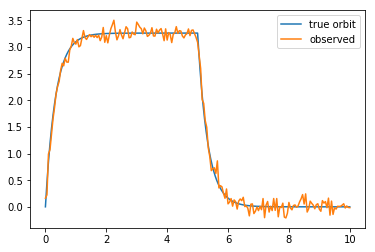

Before assimilation
cost 32842.7566541


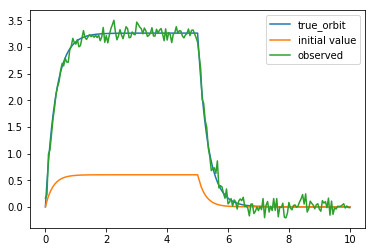

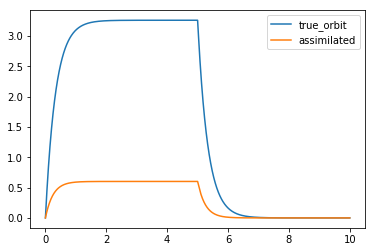

Analytical and numerical gradient comparison
gr_anal [  -499.75967191  -3689.3778787   -1361.4069129   16519.02762809
   6208.86944051]
gr_num [  -533.50148664  -3684.87963715  -1360.60465593  16509.28407616
   6205.21008386]
relative error [-0.06324596  0.00122073  0.00058963  0.00059019  0.00058972]
      fun: 93.148243616305976
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.88712971e-04,  -3.87876794e-04,  -7.05261961e-05,
         6.20638845e-04,  -1.21556372e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 38
      nit: 15
   status: 0
  success: True
        x: array([  0.01700296,  -2.86638097,  11.49895258,   0.45001947,   1.83462836])
true x0 [ 0.]


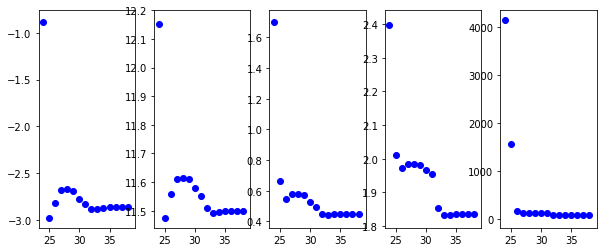

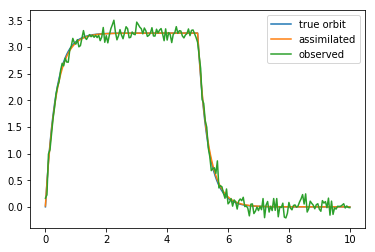

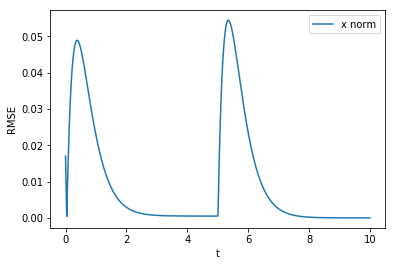

RMSE: 0.0201106709346
RMSE_natural_variability: 0.016917914
4DVar optimal cost:  93.1482436163
true cost:  96.559464357


In [22]:
ctrl = rect
pref = "/Users/konta/bitbucket/androsace/dacamp/hill/data/" + ctrl.__name__ + "/" + str(N) + "/"

M = 4
dt = 0.01

T = 10.
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

hill = Hill(ctrl)

tob = np.loadtxt(pref + "true.1.dat", ndmin=2)
tob2 = np.loadtxt(pref + "true.2.dat", ndmin=2)
#covariance_tob = np.cov(np.transpose(np.asarray(tob[0:minute_steps])))
#root_mean_trace_cov_tob = np.sqrt(np.trace(covariance_tob)/N)

RMSE_natural_variability = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,len(tob))])
#RMSE_natural_variability_T = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,minute_steps)])

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat", ndmin=2)
#covariance_obs = np.cov(np.transpose(np.asarray(obs[0:steps])))
#root_mean_trace_cov_obs = np.sqrt(np.trace(covariance_obs)/N)

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

t_plus_1 = np.arange(0., T+dt, dt)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

compare_orbit(t_plus_1, t_it_plus_1, tob[0:minute_steps+1], obs[0:steps+1], 'true orbit', 'observed')

x_opt = np.zeros(N + M)
x_opt[0:N] = tob2[np.random.randint(len(tob))]
#x_opt[0] = 0
x_opt[N] = -4.  # initial guess for a (a_true = -3.)
x_opt[N+1] = 11.  # initial guess for b (b_true = 12.)
x_opt[N+2] = 1.7  # initial guess for K (K_true = 0.3132)
x_opt[N+3] = 2.4 # initial guess for n (n_true = 1.276)

x = np.zeros((minute_steps + 1, N + M))
scheme = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, x, obs, stddev)

print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1, 0], obs[0:steps+1, 0], 'true_orbit', 'initial value', 'observed')
compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], 'true_orbit', 'assimilated')

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.000001)
print ("gr_num", gr_num)
if not(0 in gr_num):
    print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
global axLL, axL, axR, axRR, axRRR
fig , (axLL, axL, axR, axRR, axRRR) = plt.subplots(ncols=5, figsize=(10,4), sharex=False)
bnds = ((0, None), (None, None), (None, None), (0.1, None), (0, None))
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', bounds=bnds, callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
print (res)
print ("true x0", tob[0])

compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], obs[0:steps+1, 0], 'true orbit', 'assimilated', 'observed')

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE:", np.mean([np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))
#print ("RootMeanTr(cov(true)):", root_mean_trace_cov_tob)
#print ("RootMeanTr(cov(obs)):", root_mean_trace_cov_obs)
print ("RMSE_natural_variability:", RMSE_natural_variability)
#print ("RMSE_natural_variability_T:", RMSE_natural_variability_T)

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, tob, obs, stddev)
print('true cost: ', scheme_true.true_cost())

#%%
#slight_different_x0 = np.zeros(N + M)
#slight_different_x0[0:N] = np.copy(tob[0])
#slight_different_x0[N] = 8
#slight_different_x0[N+1] = 1
#slight_different_x0[N+2] = -1
#slight_different_x0[0] += 0.01
#rk4 = RungeKutta4(lorenz.gradient, N, dt, t, slight_different_x0)
#test_T = 2.0
#slight_different_orb = rk4.orbit(test_T)
#curr_steps = int(test_T/dt)
#
#compare_orbit(tob[0:curr_steps], slight_different_orb[0:curr_steps,0:N])


In [23]:
true_param = np.array([-3., 12., 0.3132, 1.276])
param_rmse = np.linalg.norm(res.x[N:N+M] - true_param)/math.sqrt(M)
print("True_Param:", true_param)
print("Estimated_Param:", res.x[N:N+M])
print ("RMSE_Param:", param_rmse)

True_Param: [ -3.      12.       0.3132   1.276 ]
Estimated_Param: [ -2.86638097  11.49895258   0.45001947   1.83462836]
RMSE_Param: 0.387197549052


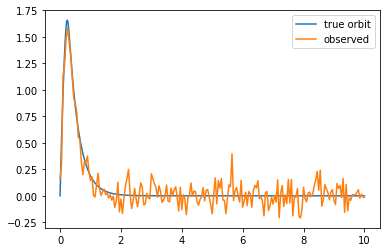

Before assimilation
cost 362.597194088


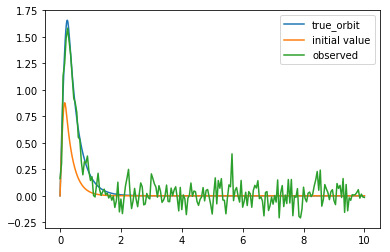

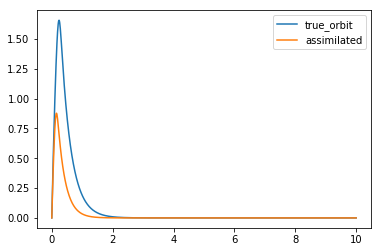

Analytical and numerical gradient comparison


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars


gr_anal [-206.69284019  -83.65850635  -32.41188575  154.05036949   -5.04423456]
gr_num [-216.7878074   -82.64292148  -32.31457504  153.02965272   -5.32085681]
relative error [-0.04656612  0.01228883  0.00301136  0.00667006 -0.05198829]
      fun: 93.962498827384294
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.96452688e-04,  -1.54025705e-04,  -3.59577371e-05,
         4.97422466e-04,  -3.10746026e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 35
   status: 0
  success: True
        x: array([  0.06248342,  -3.27872153,  11.71102429,   0.24123951,   0.89555851])
true x0 [ 0.]


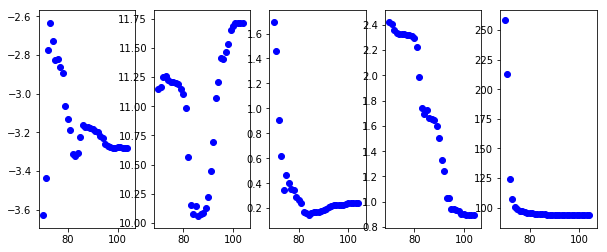

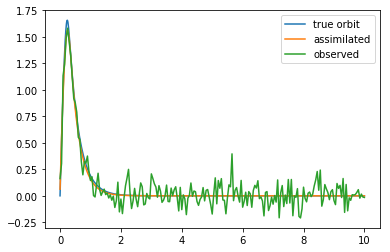

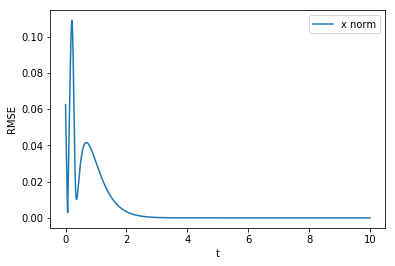

RMSE: 2.60339873985e-06
RMSE_natural_variability: 0.016917923
4DVar optimal cost:  93.9624988274
true cost:  96.5593656288


In [26]:
ctrl = impulse
pref = "/Users/konta/bitbucket/androsace/dacamp/hill/data/" + ctrl.__name__ + "/" + str(N) + "/"

M = 4
dt = 0.01

T = 10.
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

hill = Hill(ctrl)

tob = np.loadtxt(pref + "true.1.dat", ndmin=2)
tob2 = np.loadtxt(pref + "true.2.dat", ndmin=2)
#covariance_tob = np.cov(np.transpose(np.asarray(tob[0:minute_steps])))
#root_mean_trace_cov_tob = np.sqrt(np.trace(covariance_tob)/N)

RMSE_natural_variability = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,len(tob))])
#RMSE_natural_variability_T = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,minute_steps)])

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat", ndmin=2)
#covariance_obs = np.cov(np.transpose(np.asarray(obs[0:steps])))
#root_mean_trace_cov_obs = np.sqrt(np.trace(covariance_obs)/N)

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

t_plus_1 = np.arange(0., T+dt, dt)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

compare_orbit(t_plus_1, t_it_plus_1, tob[0:minute_steps+1], obs[0:steps+1], 'true orbit', 'observed')

x_opt = np.zeros(N + M)
x_opt[0:N] = tob2[np.random.randint(len(tob))]
#x_opt[0] = 0
x_opt[N] = -4.  # initial guess for a (a_true = -3.)
x_opt[N+1] = 11.  # initial guess for b (b_true = 12.)
x_opt[N+2] = 1.7  # initial guess for K (K_true = 0.3132)
x_opt[N+3] = 2.4 # initial guess for n (n_true = 1.276)

x = np.zeros((minute_steps + 1, N + M))
scheme = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, x, obs, stddev)

print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1, 0], obs[0:steps+1, 0], 'true_orbit', 'initial value', 'observed')
compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], 'true_orbit', 'assimilated')

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.000001)
print ("gr_num", gr_num)
if not(0 in gr_num):
    print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
global axLL, axL, axR, axRR, axRRR
fig , (axLL, axL, axR, axRR, axRRR) = plt.subplots(ncols=5, figsize=(10,4), sharex=False)
bnds = ((0, None), (None, None), (None, None), (0.1, None), (0, None))
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', bounds=bnds, callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
print (res)
print ("true x0", tob[0])

compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], obs[0:steps+1, 0], 'true orbit', 'assimilated', 'observed')

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE:", np.mean([np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))
#print ("RootMeanTr(cov(true)):", root_mean_trace_cov_tob)
#print ("RootMeanTr(cov(obs)):", root_mean_trace_cov_obs)
print ("RMSE_natural_variability:", RMSE_natural_variability)
#print ("RMSE_natural_variability_T:", RMSE_natural_variability_T)

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, tob, obs, stddev)
print('true cost: ', scheme_true.true_cost())

#%%
#slight_different_x0 = np.zeros(N + M)
#slight_different_x0[0:N] = np.copy(tob[0])
#slight_different_x0[N] = 8
#slight_different_x0[N+1] = 1
#slight_different_x0[N+2] = -1
#slight_different_x0[0] += 0.01
#rk4 = RungeKutta4(lorenz.gradient, N, dt, t, slight_different_x0)
#test_T = 2.0
#slight_different_orb = rk4.orbit(test_T)
#curr_steps = int(test_T/dt)
#
#compare_orbit(tob[0:curr_steps], slight_different_orb[0:curr_steps,0:N])


In [27]:
true_param = np.array([-3., 12., 0.3132, 1.276])
param_rmse = np.linalg.norm(res.x[N:N+M] - true_param)/math.sqrt(M)
print("True_Param:", true_param)
print("Estimated_Param:", res.x[N:N+M])
print ("RMSE_Param:", param_rmse)

True_Param: [ -3.      12.       0.3132   1.276 ]
Estimated_Param: [ -3.27872153  11.71102429   0.24123951   0.89555851]
RMSE_Param: 0.278884695313


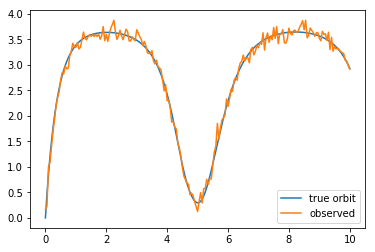

Before assimilation
cost 42960.71511


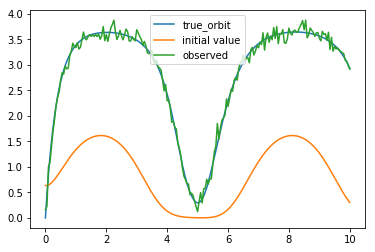

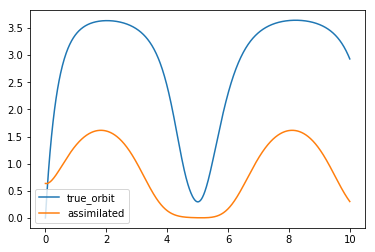

Analytical and numerical gradient comparison
gr_anal [  -275.91581412  -9446.95188548  -3384.80677485  27938.77726383
   2785.67337702]
gr_num [  -302.87136906  -9443.87105119  -3385.24548715  27932.22449691
   2773.5620024 ]
relative error [-0.08900001  0.00032623 -0.0001296   0.0002346   0.00436672]
      fun: 95.771473781780713
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.64744791, -1.53848057, -0.44951456,  6.01157415, -0.81264032])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 64
      nit: 31
   status: 0
  success: True
        x: array([  0.        ,  -2.95838957,  11.872431  ,   0.31219079,   1.25587882])
true x0 [ 0.]


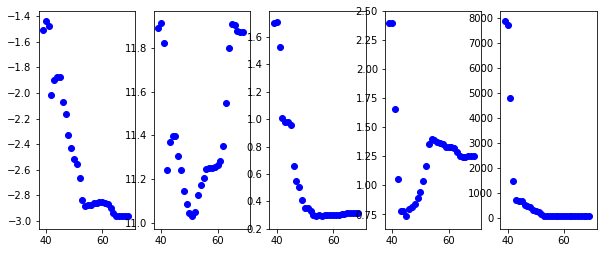

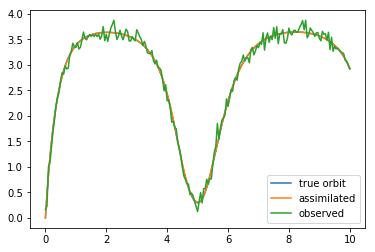

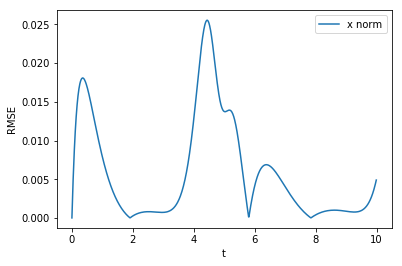

RMSE: 0.0140471980286
RMSE_natural_variability: 0.016917922
4DVar optimal cost:  95.7714737818
true cost:  96.5593804615


In [24]:
ctrl = sin
pref = "/Users/konta/bitbucket/androsace/dacamp/hill/data/" + ctrl.__name__ + "/" + str(N) + "/"

M = 4
dt = 0.01

T = 10.
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

hill = Hill(ctrl)

tob = np.loadtxt(pref + "true.1.dat", ndmin=2)
tob2 = np.loadtxt(pref + "true.2.dat", ndmin=2)
#covariance_tob = np.cov(np.transpose(np.asarray(tob[0:minute_steps])))
#root_mean_trace_cov_tob = np.sqrt(np.trace(covariance_tob)/N)

RMSE_natural_variability = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,len(tob))])
#RMSE_natural_variability_T = np.mean([np.linalg.norm(tob2[i] - tob[i])/math.sqrt(N) for i in range(0,minute_steps)])

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat", ndmin=2)
#covariance_obs = np.cov(np.transpose(np.asarray(obs[0:steps])))
#root_mean_trace_cov_obs = np.sqrt(np.trace(covariance_obs)/N)

t = np.arange(0., T, dt)
t_it = np.arange(0., T, dt*it)

t_plus_1 = np.arange(0., T+dt, dt)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

compare_orbit(t_plus_1, t_it_plus_1, tob[0:minute_steps+1], obs[0:steps+1], 'true orbit', 'observed')

x_opt = np.zeros(N + M)
x_opt[0:N] = tob2[np.random.randint(len(tob))]
#x_opt[0] = 0
x_opt[N] = -4.  # initial guess for a (a_true = -3.)
x_opt[N+1] = 11.  # initial guess for b (b_true = 12.)
x_opt[N+2] = 1.7  # initial guess for K (K_true = 0.3132)
x_opt[N+3] = 2.4 # initial guess for n (n_true = 1.276)

x = np.zeros((minute_steps + 1, N + M))
scheme = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, x, obs, stddev)

print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1, 0], obs[0:steps+1, 0], 'true_orbit', 'initial value', 'observed')
compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], 'true_orbit', 'assimilated')

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.000001)
print ("gr_num", gr_num)
if not(0 in gr_num):
    print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
global axLL, axL, axR, axRR, axRRR
fig , (axLL, axL, axR, axRR, axRRR) = plt.subplots(ncols=5, figsize=(10,4), sharex=False)
bnds = ((0, None), (None, None), (None, None), (0.1, None), (0, None))
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', bounds=bnds, callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
print (res)
print ("true x0", tob[0])

compare_orbit3(t_plus_1, t_plus_1, t_it_plus_1, tob[0:minute_steps+1, 0], scheme.x[0:minute_steps+1,0], obs[0:steps+1, 0], 'true orbit', 'assimilated', 'observed')

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE:", np.mean([np.linalg.norm(scheme.x[i,0] - tob[i,0])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))
#print ("RootMeanTr(cov(true)):", root_mean_trace_cov_tob)
#print ("RootMeanTr(cov(obs)):", root_mean_trace_cov_obs)
print ("RMSE_natural_variability:", RMSE_natural_variability)
#print ("RMSE_natural_variability_T:", RMSE_natural_variability_T)

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(hill.gradient, hill.gradient_adjoint, N, T, dt, it, tob, obs, stddev)
print('true cost: ', scheme_true.true_cost())

#%%
#slight_different_x0 = np.zeros(N + M)
#slight_different_x0[0:N] = np.copy(tob[0])
#slight_different_x0[N] = 8
#slight_different_x0[N+1] = 1
#slight_different_x0[N+2] = -1
#slight_different_x0[0] += 0.01
#rk4 = RungeKutta4(lorenz.gradient, N, dt, t, slight_different_x0)
#test_T = 2.0
#slight_different_orb = rk4.orbit(test_T)
#curr_steps = int(test_T/dt)
#
#compare_orbit(tob[0:curr_steps], slight_different_orb[0:curr_steps,0:N])


In [25]:
true_param = np.array([-3., 12., 0.3132, 1.276])
param_rmse = np.linalg.norm(res.x[N:N+M] - true_param)/math.sqrt(M)
print("True_Param:", true_param)
print("Estimated_Param:", res.x[N:N+M])
print ("RMSE_Param:", param_rmse)

True_Param: [ -3.      12.       0.3132   1.276 ]
Estimated_Param: [ -2.95838957  11.872431     0.31219079   1.25587882]
RMSE_Param: 0.0678438621632


# 次週の目標
- Weak-constraint 4D-Varコードの実装
- 二次変分によるパラメータと状態変数の信頼区間推定
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装